# Latent Dirichlet Allocation (LDA)

This notebook attempts to use LDA to model the topics in a group of Bugzilla bugs through text analysis.

Also want to use [this approach](https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/) to use grid search to determine the most meaningful number of topics that exist in the text.

# Google Colaborator Setup

This section contains cells to set up the Google Colaborator environment to run this notebook. The following are needed:

* Clone the Github repository
* Install Spacy
* Install pyLDAVis

## Note: The runtime may need to be restarted after installing Spacy.

In [30]:
!pip install spacy

In [31]:
!python -m spacy download en_core_web_sm


    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en_core_web_sm

    You can now load the model via spacy.load('en_core_web_sm')



In [32]:
!pip install pyLDAVis

In [33]:
!git clone https://github.com/HSV-AI/bug-analysis.git
%cd bug-analysis

Cloning into 'bug-analysis'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 64 (delta 1), reused 0 (delta 0), pack-reused 58
Unpacking objects: 100% (64/64), done.
/content/bug-analysis/bug-analysis


# Loading Bugzilla Data

In [34]:
%run LoadData.ipynb

Loaded 2000 bugs
Created DataFrame named df
['id', 'title', 'component', 'product', 'text', 'reporter', 'commenters']


In [0]:
#Global Imports
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

Now let's take a look at the content of the bugs that we retrieved.

First we can check the distribution of bugs across the defined components:

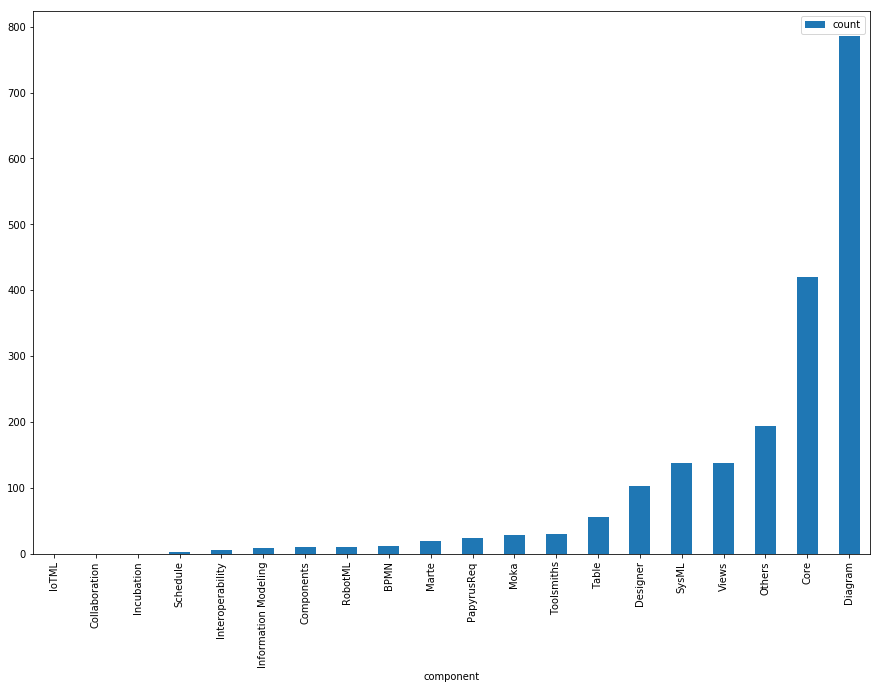

In [7]:
grouped = df.loc[:,['id','component']].groupby('component').count()
grouped.columns = ['count']
grouped.sort_values(by='count').plot(kind='bar', figsize=(15,10))
plt.show()

# Cleaning Data

If you have ever worked with software bugs, you know that many of them are lacking enough information to be useful. On the other hand, some will take on a life of their own and change direction over time.

In this analysis, we will try to remove the bugs that have little text as well as those that have an overwhelming length of text.

We start by showing the distribution of the length, followed by calculation of the 3*sigma cuttof points. Seeing that this method will not work for this non-normal distribution, we use the Interquartile Range (IQR) instead.

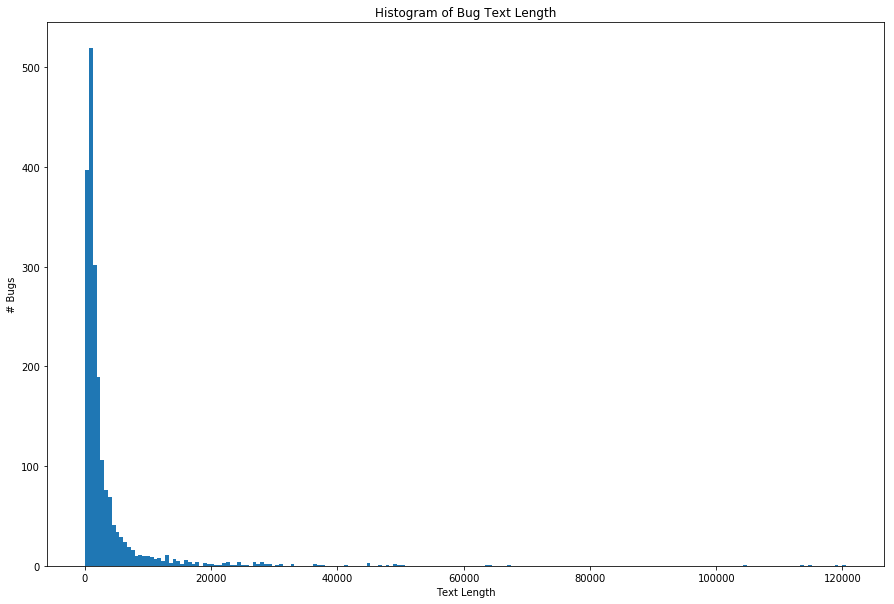

Min/Max length of any bug is 34/120563

Mean of text length is 3532
 
Standard Deviation of the text length is 8250

3 Sigma cuttoff values are lower: -21218 and upper: 28283

Interquartile Range is 2215

IQR cuttoff values are lower: -2585 and upper: 6275



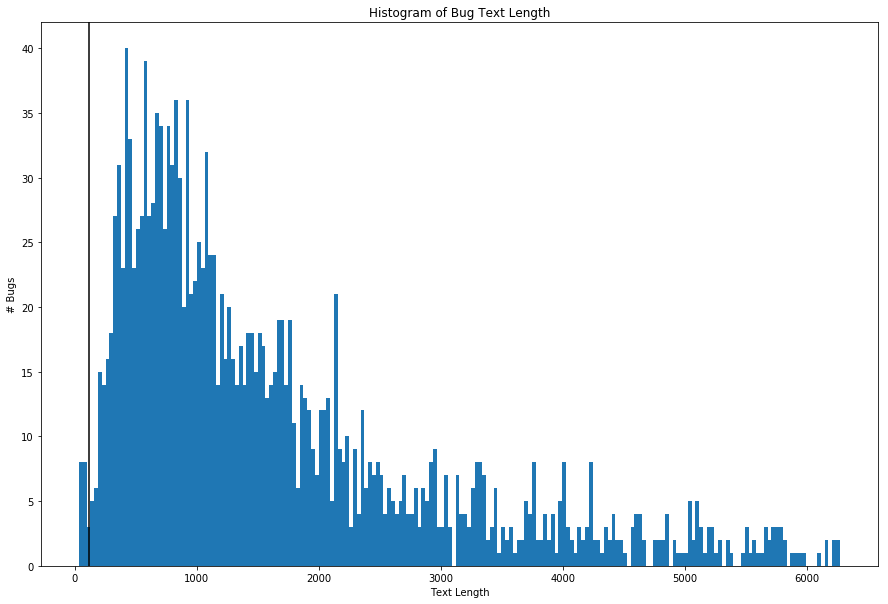

Using a manually defined lower value of 120 (See Vertical Black Line Above)

The resulting set contains 1750 bugs



In [36]:
df['length'] = df['text'].str.len()
text_arr = df.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.hist(text_arr, bins=200)
plt.show()

print('Min/Max length of any bug is %d/%d\n'%(np.min(text_arr), np.max(text_arr)))

# Find the values bounding the 98 percentile
# May want to filter these later
mean = np.mean(text_arr)
print('Mean of text length is %d\n ' % mean)
stdev = np.std(text_arr)
print('Standard Deviation of the text length is %d\n' % stdev)
#Compute 3sigma
sigma = 3*stdev
lower = mean - sigma
upper = mean + sigma

print('3 Sigma cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

q25, q75 = np.percentile(text_arr, 25), np.percentile(text_arr, 75)
iqr = q75 - q25
print('Interquartile Range is %d\n' % iqr)

cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off

print('IQR cuttoff values are lower: %d and upper: %d\n' % (lower, upper))

trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]

# Let's get a look at these values
text_arr = trimmedDF.loc[:,'length'].values

# Plot a histogram of the text length
plt.figure(figsize=(15,10))
plt.xlabel('Text Length')
plt.ylabel('# Bugs')
plt.title('Histogram of Bug Text Length')
plt.axvline(x=120, color='k')
plt.hist(text_arr, bins=200)
plt.show()

print("Using a manually defined lower value of 120 (See Vertical Black Line Above)\n")
lower = 120
trimmedDF = df.loc[(df['length'] > lower) & (df['length'] < upper)]
text_arr = trimmedDF.loc[:,'length'].values
print('The resulting set contains %d bugs\n' % len(text_arr))

# Create a Tokenize Method
This method provides a simple list of words from the text. We will go ahead and run this against the bugs that we have loaded to find the total number of tokens.


In [0]:
nlp = spacy.load("en_core_web_sm")

exception_regex = re.compile(r".+Exception[^\n].*\s+at", re.MULTILINE | re.IGNORECASE)
greater_regex = re.compile(r"^> .*$", re.MULTILINE | re.IGNORECASE)
gerrit_created_regex = re.compile(r"New Gerrit change created: [^\ ]+", re.MULTILINE | re.IGNORECASE)
gerrit_merge_regex = re.compile(r"Gerrit change [^\s]+ was merged to [^\.]+\.", re.MULTILINE | re.IGNORECASE)
gerrit_commit_regex = re.compile(r"Commit: [^\ ]+", re.MULTILINE | re.IGNORECASE)

filter = ['VERB', 'NOUN', 'PROPN']

def tokenize(text):
    text = greater_regex.sub("", text)
    text = exception_regex.sub("", text)
    text = gerrit_created_regex.sub("", text)
    text = gerrit_merge_regex.sub("", text)
    text = gerrit_commit_regex.sub("", text)
    filtered_tokens = []
    
    doc = nlp(text)
    for sent in doc.sents:
        for token in sent:
            if re.fullmatch('[a-zA-Z]+', token.text):
#            if token.pos_ in filter and re.fullmatch('[a-zA-Z]+', token.text):
                filtered_tokens.append(token.lemma_)
    return filtered_tokens



Let's run this tokenizer across all of our text and see how many words we have.

In [0]:
# The following piece will count up all of the words in the vocabulary. Usefull information, but it takes a while.
totalvocab = []
count = 0

for i in trimmedDF.loc[:,'text']:
#     count = count+1
    allwords = tokenize(i)
    totalvocab.extend(allwords)
# #     if count > 20:
#         break
print('Total word count: '+str(len(totalvocab)))
print('Total unique words: '+str(len(set(totalvocab))))

# Create a CountVectorizer


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.5, min_df=10, stop_words=nlp.Defaults.stop_words, tokenizer=tokenize)
# tf_vectorizer = CountVectorizer(min_df=5, stop_words='english', tokenizer=tokenize)
%time tf = tf_vectorizer.fit_transform(trimmedDF.loc[:,'text'])
tf_feature_names = tf_vectorizer.get_feature_names()
# Materialize the sparse data
dense = tf.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Data Sparsicity: ", ((dense > 0).sum()/dense.size)*100, "%")

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-PRON-', 'regard', 'use', 'whatev'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 4min 4s, sys: 1min 40s, total: 5min 44s
Wall time: 2min 53s
Data Sparsicity:  2.795703125 %


In [0]:
from sklearn.decomposition import LatentDirichletAllocation

# Run LDA
%time lda = LatentDirichletAllocation(n_components=7, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

print("\nLog Likelihood: %d ## Perplexity: %d\n" % ((lda.score(tf)), lda.perplexity(tf)))

# Print the top 5 words in each topic
num_words = 5
print('LDA Topics: ')
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx), " ".join([tf_feature_names[i] for i in topic.argsort()[:-num_words - 1:-1]]))



CPU times: user 4.05 s, sys: 594 µs, total: 4.05 s
Wall time: 4.06 s

Log Likelihood: -967253 ## Perplexity: 395

LDA Topics: 
Topic 0: activity create diagram link node
Topic 1: stereotype property element type sysml
Topic 2: create diagram use package menu
Topic 3: model create diagram property element
Topic 4: papyrus plugin state error eclipse
Topic 5: diagram bug display port use
Topic 6: model profile file papyrus import


# Grid Search Optimization

We can run Grid Search across a list of parameters to identify the optimal parameters to use for the desired outcome.

In [0]:
from sklearn.model_selection import GridSearchCV

# Define Search Param
search_params = {'n_components': [6, 8, 10], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation(learning_method='online')

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(tf)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [6, 8, 10], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [0]:
# Best Model
lda = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", lda.perplexity(tf))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 6}
Best Log Likelihood Score:  -244834.677917
Model Perplexity:  492.123868465


# Measure Topic Distribution

In [0]:
topic_labels = []
for topic_idx, topic in enumerate(lda.components_):
    label_string = "Topic "+str(topic_idx)+ ": "+" ".join([tf_feature_names[i] for i in topic.argsort()[:-1 - 1:-1]])
    topic_labels.append(label_string)
    print(label_string)


Topic 0: activity
Topic 1: stereotype
Topic 2: create
Topic 3: model
Topic 4: papyrus
Topic 5: diagram
Topic 6: model


In [0]:
def getLDATopic(row):
    try:
        tf_text = tf_vectorizer.transform([row['text']])
        doc_topic_dist = np.matrix(lda.transform(tf_text))
        #quick and dirty for now. May need to check for separation of values
        return doc_topic_dist.argmax()
    except:
        print(row)
    return -1.0
            
%time trimmedDF.loc[:,'topic'] = trimmedDF.apply(getLDATopic, axis=1)


CPU times: user 4min 2s, sys: 1min 38s, total: 5min 40s
Wall time: 2min 51s


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [0]:
import sklearn.metrics as metrics

print("Homogeneity: %0.3f" % metrics.homogeneity_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Completeness: %0.3f" % metrics.completeness_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("V-measure: %0.3f" % metrics.v_measure_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(trimmedDF.loc[:,'component'], trimmedDF.loc[:,'topic']))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(tf, trimmedDF.loc[:,'topic'], sample_size=1000))


Homogeneity: 0.124
Completeness: 0.124
V-measure: 0.124
Adjusted Rand-Index: 0.045
Silhouette Coefficient: -0.058


# Visualize the Results

This section uses several methods to visualize the results of the LDA.

Using PCA, create a 2D Visualizaton of the TF/IDF Matrix.

Components per Topic:


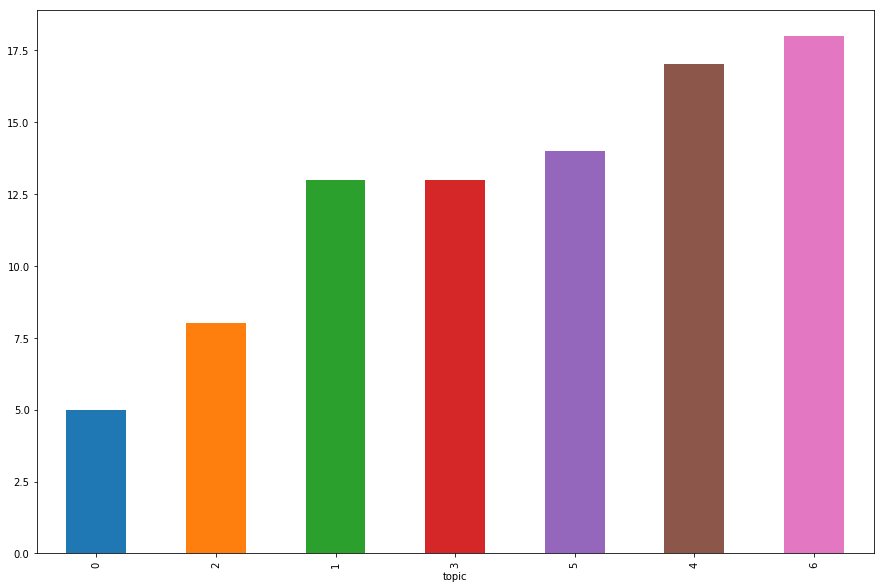

Bugs per Topic:


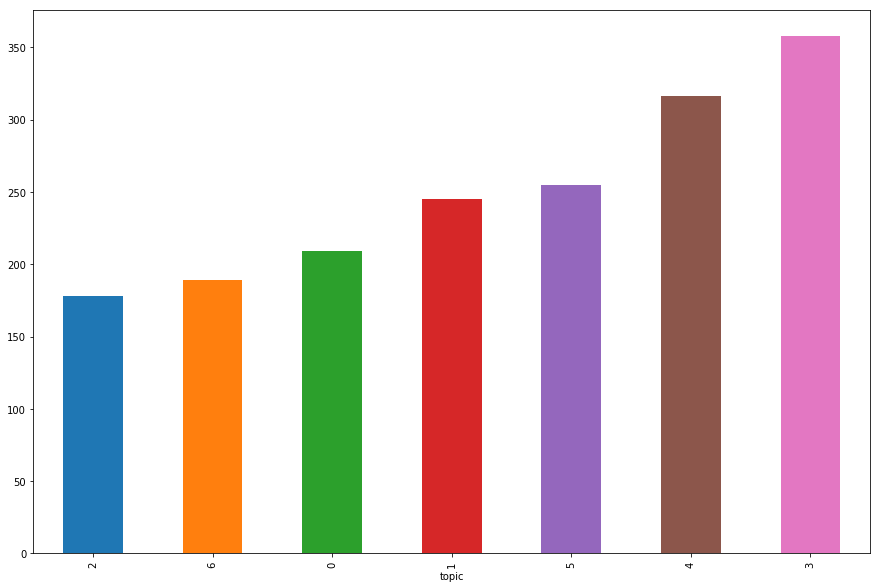

In [0]:
print("Components per Topic:")
grouped = trimmedDF.loc[:,['id','component','topic']].groupby('topic').component.nunique()
grouped.columns = ['count', 'component']
grouped.sort_values().plot(kind='bar', figsize=(15,10))
plt.show()

print("Bugs per Topic:")
grouped = trimmedDF.loc[:,['id','component','topic']].groupby('topic').component.count()
grouped.columns = ['count', 'component']
grouped.sort_values().plot(kind='bar', figsize=(15,10))
plt.show()



In [0]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
pyLDAvis.display(panel)


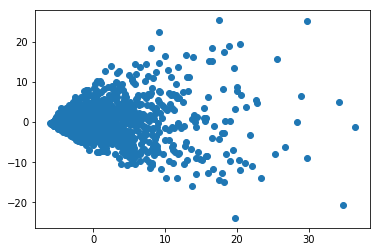

In [0]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

X = tf.todense()

pca = PCA(n_components=2).fit(X)
data2D = pca.transform(X)
plt.scatter(data2D[:,0], data2D[:,1])

plt.show()


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


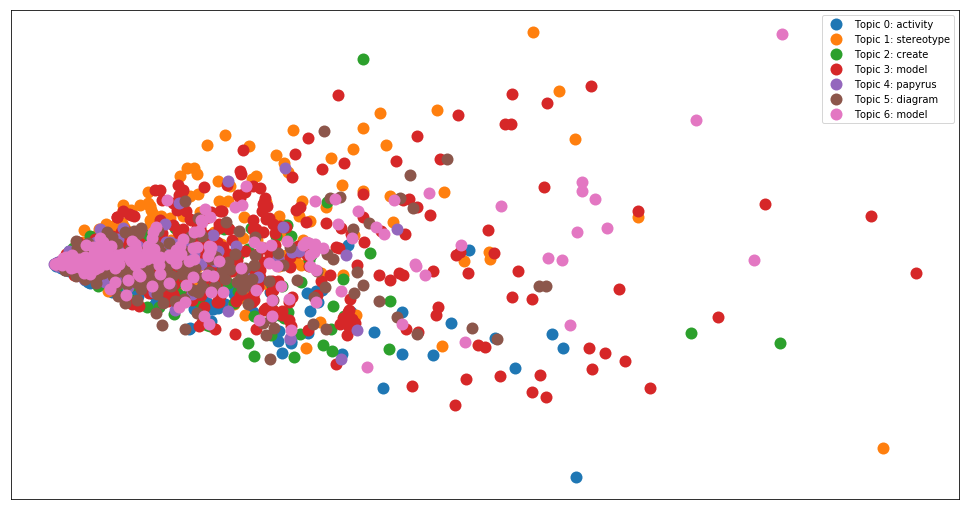

In [0]:
xs, ys = data2D[:, 0], data2D[:, 1]
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=trimmedDF.loc[:,'id'])) 
df = pd.DataFrame(dict(x=xs, y=ys, label=trimmedDF.loc[:,'topic'], title=trimmedDF.loc[:,'id'])) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=topic_labels[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


# I'll have another

Now try the same thing with MDS for reducing to 2 dimensions.

CPU times: user 2min 35s, sys: 1min 23s, total: 3min 59s
Wall time: 2min


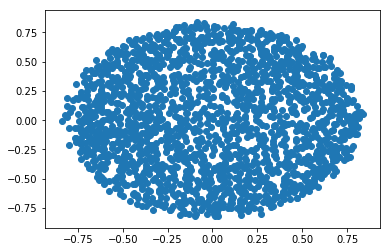

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tf)

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)
plt.scatter(pos[:,0], pos[:,1])

plt.show()



/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


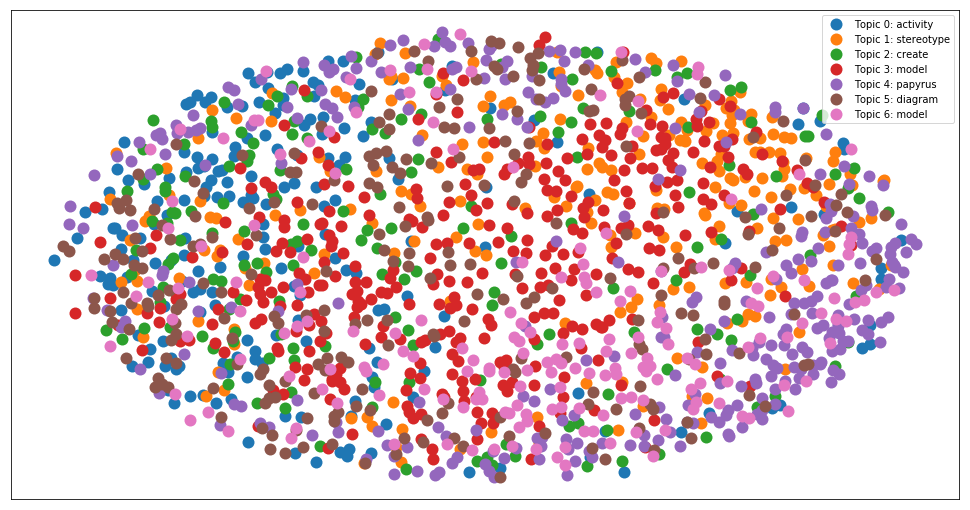

In [0]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
# df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=trimmedDF.loc[:,'id'],)) 
xs, ys = pos[:, 0], pos[:, 1]
df = pd.DataFrame(dict(x=xs, y=ys, label=trimmedDF.loc[:,'topic'], title=trimmedDF.loc[:,'id'],)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
#            label=cluster_names[name], color=cluster_colors[name],
#            label=name,
            label=topic_labels[name],
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the bug id
#for i in range(len(df)):
#    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

plt.show() #show the plot


# Doc2Vec


In [0]:
import gensim
def read_corpus():
  for i, row in trimmedDF.iterrows():
    yield gensim.models.doc2vec.TaggedDocument(tokenize(row['text']), [row['id']])

train_corpus = list(read_corpus())

In [0]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)

In [0]:
model.build_vocab(train_corpus)

In [41]:
%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 40.8 s, sys: 1.29 s, total: 42.1 s
Wall time: 22.7 s


In [48]:
model.infer_vector(['hello', 'world'])

array([ 0.14544809, -0.02516535, -0.05564135,  0.01063902, -0.13736755,
       -0.1307791 ,  0.0971382 , -0.14448231,  0.08995052, -0.21516584,
       -0.14360894,  0.38654488, -0.02916547,  0.1359815 , -0.06974062,
        0.15075664, -0.05637763,  0.12694678,  0.03004157, -0.22146203,
        0.0177248 ,  0.03915979, -0.03980753,  0.13580492,  0.10412644,
        0.05245393, -0.27156237, -0.3986208 ,  0.16720699,  0.20061524,
       -0.05200428, -0.17069723,  0.05118807,  0.02519886,  0.10744876,
       -0.04958264, -0.20247218,  0.05254999, -0.29110783, -0.08007907,
       -0.28180122, -0.1522754 , -0.10253213,  0.01506065, -0.09269293,
       -0.13898319,  0.00392292, -0.0392512 ,  0.07117523, -0.2585056 ],
      dtype=float32)

In [68]:
import random
# Pick a random document from the test corpus and infer a vector from the model
doc_id = random.randint(0, len(train_corpus) - 1)
doc = train_corpus[doc_id]
text = trimmedDF.loc[trimmedDF['id'] == doc.tags[0]].iloc[0]['text']
print(doc.tags[0],text)

inferred_vector = model.infer_vector(doc.words)
sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))

print()
print(sims[1][0])
text = trimmedDF.loc[trimmedDF['id'] == sims[1][0]].iloc[0]['text']
print(doc.tags[0],text)


482353 [SysML 1.4][IBD] not Possible to display connector typed by associationBlock I have created an internal block diagram for a block with at least 2 parts.
I've drawn a connector between two parts and I was able to type it with an association class. However, I was not able to draw this associationclass in the IBD.
I added the block stereotype to the created associationclass. Afterwards I was still unable to visualize the type of the connector, which is now an associationblock.

I think two things are incorrect here:
- I should be able to directly create an associationblock instead of having to create an association class and stereotyping it with block
- I should be able to visualize the associationblock type of the connector in the internal block diagram. (I understand if I can't visualize an associationclass) Creation of association block must done in the BDD see bug 417818

AssociationClass can be draw in IBD, but this is connector typed by an association Block, and a rectangle m

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
